## import libraries

In [117]:
import os, sys, shutil, json
from pytorch_pretrained_vit import ViT
from torchsummary import summary
from PIL import Image
from glob import glob
import random
import torch
from torchvision import transforms
import pandas as pd

## flow control

In [133]:
summarize_model = False
show_image_example = True
# regenerate_data = False

## set up device and load pretrained model

In [130]:
device = torch.device("cuda:0") if torch.cuda.is_available() == True else torch.device("cpu")
print("Using device:", device)
model = ViT("B_16_imagenet1k", pretrained=True)
model.to(device)
if summarize_model:
    summary(model, input_size=(3,384,384)) # must be 384 for B_16

Using device: cuda:0
Loaded pretrained weights.


## split raw images into train and validation folders if needed

In [131]:
def prepare_train_val(root_path, targ_path, val_size=0.2, seed=42):
    files = glob(root_path)
    n_files = len(files)
    random.seed(seed)
    random.shuffle(files)
    os.makedirs(os.path.dirname(f"{targ_path}/train"), exist_ok=True)
    os.makedirs(os.path.dirname(f"{targ_path}/val"), exist_ok=True)
    # print(files)
    train_files, val_files = [], []
    for f in files[:int(n_files*(1-val_size))]:
        shutil.copy(f, f"{targ_path}/train")
        train_files.append(f)
    for f in files[int(n_files*(1-val_size)):]:
        shutil.copy(f, f"{targ_path}/val")
        val_files.append(f)
    return train_files, val_files

In [132]:
train_files, val_files = prepare_train_val("/mnt/data/projects/wankun01/playground/cv/rawdata/images/*", "/mnt/data/projects/wankun01/playground/cv/ViT-PyTorch/data")

## load true labels for the data

In [134]:
labels = pd.read_csv("/mnt/data/projects/wankun01/playground/cv/rawdata/annotations.csv")
labels = labels[["file_name", "category"]]
labels.head()

,file_name,category
0,000_0001.png,0
1,000_0002.png,0
2,000_0003.png,0
3,000_0010.png,0
4,000_0011.png,0


## load labels that model can predict

In [135]:
labels_map = json.load(open('../examples/simple/labels_map.txt'))
labels_map = [labels_map[str(i)] for i in range(1000)]
print(labels_map[0:5])

['tench, Tinca tinca', 'goldfish, Carassius auratus', 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias', 'tiger shark, Galeocerdo cuvieri', 'hammerhead, hammerhead shark']


## perform single image prediction example

In [136]:
def make_single_prediction(img_path, model, device="cpu", show_image_example=False):
    img = Image.open(img_path)
    if show_image_example:
        img.show()

    # Preprocess image
    tsfm = transforms.Compose([transforms.Resize(model.image_size), 
                               transforms.ToTensor(), 
                               transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
                              ])
    img = tsfm(img).unsqueeze(0)
    print("Image shape is:", img.shape)
    model.eval()
    with torch.no_grad():
        outputs = model(img.to(device)).squeeze(0)
    print('-----')
    for idx in torch.topk(outputs, k=3).indices.tolist():
        prob = torch.softmax(outputs, -1)[idx].item()
        print('[{idx}] {label:<75} ({p:.2f}%)'.format(idx=idx, label=labels_map[idx], p=prob*100))

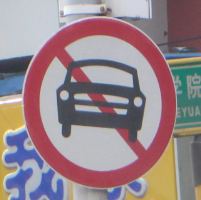

Image shape is: torch.Size([1, 3, 384, 384])
-----
[919] street sign                                                                 (84.90%)
[468] cab, hack, taxi, taxicab                                                    (3.44%)
[734] police van, police wagon, paddy wagon, patrol wagon, wagon, black Maria     (1.86%)


In [141]:
make_single_prediction(train_files[12], model, device=device, show_image_example=show_image_example)

## try finetune on the train dataset

In [144]:
## create our dataset 
from  torch.utils.data import Dataset
class TrafficSignDataset(Dataset):
    pass

In [ ]:
model.train() # set to train mode, so all weights become trainable now.
tsfm = transforms.Compose([transforms.Resize(model.image_size), 
                               transforms.ToTensor(), 
                               transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
                              ])

for img in train_files:
    img = tsfm(img).unsqueeze(0)